# Lab 3: Kalman Filtering and Online Bayesian Inference

### Lab Date: Wednesday, February 12

### Due: Wednesday, February 19

## Instructions

Work with your lab group to complete the following notebook. It will be reviewed by your peers in lab next week (Wednesday, February 19th). 

This lab introduces you to the Kalman filter, a fundamental tool for data assimilation in dynamical systems. The Kalman filter is an iterated application of a Gaussian likelihood, a Gaussian prior on the mean, and a linear update model to represent a dynamical system with a measurement protocol. Historically, this approach was state-of-the-art for online prediction problems such as weather forecasting until recent advances in AI.

If you are new to working in python, or in a Jupyter notebook, please ask your lab members for help. If you notice a lab member struggling, and have experience, please offer your help.

Please see this [Ed post](https://edstem.org/us/courses/74615/discussion/6107459) for corrections, questions, and discussion. If you would rather work with your own copy of the files, I have uploaded a zip folder there with the lab materials. You may use the same procedure you used last week to work with that folder. 

Corrections to the lab will be pushed directly to this notebook. We will only push corrections to the text, which is set to read only to prevent merge conflicts. In the event of a merge conflict, save your notebook under a different name, and click the link that launches the lab from the schedule on the [stat238 homepage](https://stat238.berkeley.edu/spring-2025/) again. Then, check for discrepancies. If you can't find them, or resolve the conflict, contact us.

In [10]:
# load whatever packages you prefer here. I've added a reference list
import numpy as np
import matplotlib.pyplot as plt

## A simple harmonic oscillator

Define the dynamical system for a simple harmonic oscillator: $$\frac{d^2 x}{d t^2} + \omega^2 x =0$$

## Step 1: Define the State-Space Model
A state-space model consists of a system equation and a measurement equation. The system equation describes how the true state evolves over time, while the measurement equation describes how observations are obtained. 

The state equation is given by:
$$ x_{t+1} = A x_t + w_t $$
where $x_t$ is the state vector at time $t$, $A$ is the transition matrix, and $w_t$ is process noise, assumed to be Gaussian with covariance $Q$.

The measurement equation is given by:
$$ y_t = H x_t + v_t $$
where $y_t$ is the observed measurement, $H$ is the observation matrix, and $v_t$ is measurement noise, assumed to be Gaussian with covariance $R$.

In [7]:
# Define the state-space model
dt = 0.1  # Time step
omega = 1.0  # Natural frequency
A = np.array([[1, dt], [-omega**2 * dt, 1]])  # State transition matrix
H = np.array([[1, 0]])  # Measurement matrix
Q = np.eye(2) * 0.01  # Process noise covariance
R = np.eye(1) * 0.1  # Measurement noise covariance

# Initialize state estimate and covariance
x_est = np.array([[1], [0]])  # Initial position and velocity
P = np.eye(2) * 1.0  # Initial uncertainty

# Simulate noisy measurements
time_steps = 100
true_states = []
measurements = []
for _ in range(time_steps):
    x_est = A @ x_est + np.random.multivariate_normal(mean=[0, 0], cov=Q).reshape(-1, 1) # Propagate state forward
    measurement = H @ x_est + np.random.normal(0, np.sqrt(R[0, 0]))  # Add measurement noise
    true_states.append(x_est.flatten())
    measurements.append(measurement.flatten())

## Step 2: Compute the Prediction Step
In this step, we use the state equation to predict the next state based on the current estimate. This involves two calculations:

1. **State Prediction:**
   $$ \hat{x}_{t|t-1} = A x_{t-1|t-1} $$
   This equation propagates the previous estimate through the state model to predict the next state.

2. **Covariance Prediction:**
   $$ P_{t|t-1} = A P_{t-1|t-1} A^T + Q $$
   Here, we compute the predicted covariance, which accounts for the uncertainty in the process model.

## Step 3: Compute the Kalman Gain
The Kalman Gain determines how much weight should be given to the new measurement versus the predicted state. It is calculated as:
$$ K_t = P_{t|t-1} H^T (H P_{t|t-1} H^T + R)^{-1} $$
This equation balances the confidence in the measurement against the predicted uncertainty.

## Step 4: Compute the Update Step
Once a new measurement $y_t$ is received, the state estimate is updated. This is done using:

1. **State Update:**
   $$ x_{t|t} = \hat{x}_{t|t-1} + K_t (y_t - H \hat{x}_{t|t-1}) $$
   This equation corrects the predicted state using the difference (innovation) between the actual measurement and the predicted measurement.

2. **Covariance Update:**
   $$ P_{t|t} = (I - K_t H) P_{t|t-1} $$
   Here, the covariance is updated to reflect the reduced uncertainty after incorporating the new measurement.

## Step 5: Implement the Kalman Filter
Now that we have derived the equations, we implement the Kalman Filter iteratively over multiple time steps. At each step, we:
1. Use the state transition model to predict the next state.
2. Compute the Kalman Gain to determine the weight of the new measurement.
3. Update the state estimate based on the new measurement.
4. Update the covariance to reflect new uncertainty levels.
5. Repeat for all incoming measurements.

In [8]:
# Implement the Kalman Filter
filtered_states = []
for z in measurements:
    # Prediction Step
    x_pred = A @ x_est
    P_pred = A @ P @ A.T + Q
    
    # Compute Kalman Gain
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
    
    # Update Step
    x_est = x_pred + K @ (z - H @ x_pred)
    P = (np.eye(2) - K @ H) @ P_pred
    
    filtered_states.append(x_est.flatten())

## Step 6: Visualizing the Results
To understand how well the Kalman Filter performs, we plot the following elements:
1. **True State**: The actual underlying system state.
2. **Filtered State**: The estimated state obtained from the Kalman Filter.
3. **Measurements**: The noisy observations received over time.

The plot helps visualize how closely the Kalman Filter is able to track the true state despite noisy measurements. We expect the filtered state to be smoother than the measurements and follow the trend of the true state closely.

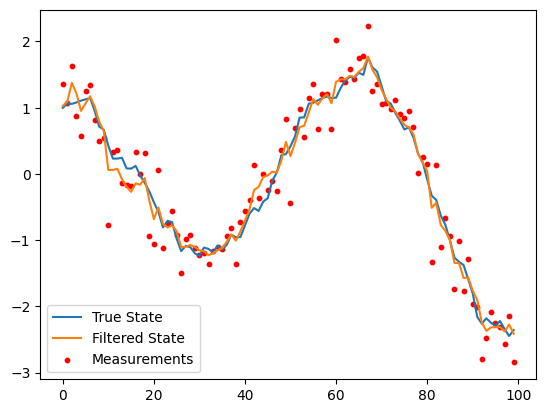

In [9]:
# Plot the results
plt.plot([s[0] for s in true_states], label='True State')
plt.plot([s[0] for s in filtered_states], label='Filtered State')
plt.scatter(range(time_steps), [m[0] for m in measurements], label='Measurements', color='red', s=10)
plt.legend()
plt.show()